In [1]:
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2
import spatialpy
import numpy
import matplotlib.pyplot as plt
import math

In [2]:
class All(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return True

class Walls(spatialpy.Geometry):
    ''' Outside of the unit square'''
    def inside(self, x, on_boundary):
        if x[0] < 0.0 or x[0] > 1.0 or \
           x[1] < 0.0 or x[1] > 1.0:
            return True
        return False

In [3]:
class ChemicalGradient(spatialpy.Model):
    def __init__(self):
        spatialpy.Model.__init__(self,"ChemicalGradient")
        
        # System constants
        D = 0.1              # diffusion constant of the chemical species
        cLow = 50            # low value for boundary condition concentration
        cHigh = 100          # high value for boundary condition concentration
        
        nxF,nyF = 50,50      # number of fluid particles in x and y-direction
        nu  = 1.             # fluid viscosity
        L   = 1.             # characteristic lenght of the cavity (= width = height)
        nW  = 2              # number of wall points
        rho = 1.             # fluid density

        # Discretization
        nxTot = nxF + 2*nW # total number of particles in x-direction (including walls)
        nyTot = nyF + 2*nW # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx,dy = L/(nxF-1),L/(nyF-1)
        xLim = ((0-(nW-1)*dx),1+(nW-1)*dx)
        yLim = ((0-(nW-1)*dy),1+(nW-1)*dy)
        
        # Compute volume and mass per particle
        vol = (xLim[1]-xLim[0])*(yLim[1]-yLim[0])*1.0 # in 2D simulations, consider z-lenght = 1
        mPP = rho*vol/(nxTot*nyTot)                   # density * total volume / total number of particles
        
        # Create mesh object
        print("xlim={0} ylim={1} nx={2} ny={3}".format(xLim, yLim, nxTot,nyTot))
        self.domain = spatialpy.Domain.create_2D_domain(
            xLim ,yLim , nxTot, nyTot, 
            type_id=1, mass=mPP, nu = nu, fixed=True)
        
        # Define Subdomains
        self.set_type(All(), 1)
        self.set_type(Walls(), 2, fixed=True)
        
        # Define a chemical Species
        self.add_species(spatialpy.Species('A', diffusion_coefficient=D))
        
        # Boundary conditions
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmax=0.0,
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin=1.0,
            species = 'A',
            deterministic=True,
            value    = cHigh
        ))
        
        # Time span
        #self.timespan(numpy.linspace(0,5,1000))
        self.timespan(numpy.linspace(0,0.15,11),timestep_size=1e-5)

In [4]:
model = ChemicalGradient()

xlim=(-0.02040816326530612, 1.0204081632653061) ylim=(-0.02040816326530612, 1.0204081632653061) nx=54 ny=54


In [5]:
print("model.tspan        ",model.tspan)
print("model.timestep_size",model.timestep_size)
print("model.num_timesteps",model.num_timesteps)
print("model.output_freq  ",model.output_freq)
print("model.timespan_steps  ",model.timespan_steps)

model.tspan         [0.    0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15 ]
model.timestep_size 1e-05
model.num_timesteps 15000
model.output_freq   1500
model.timespan_steps   [    0  1500  3000  4500  6000  7500  9000 10500 12000 13500 15000]


In [6]:
sol = spatialpy.Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 454 ms, sys: 16.6 ms, total: 471 ms
Wall time: 5.87 s


In [7]:
%time result = sol.run()

CPU times: user 353 µs, sys: 4.02 ms, total: 4.37 ms
Wall time: 15.7 s


In [8]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type',index=0,time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(result.get_timespan()[time]))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)

def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_step(key,time=i)
        
def plot_cross(key='type',index=0,time=0,y_cross=None):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    if y_cross is None:
        m=numpy.min(pts[:,1])
    else:
        m = y_cross
    p_ndx = pts[:,1]==m
    plt.plot(pts[p_ndx,0],d[p_ndx])
    #plt.axis('equal')
    plt.title('t={0} y={1}'.format(result.get_timespan()[time],m))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)

def plot_all_cross(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_cross(key,time=i)


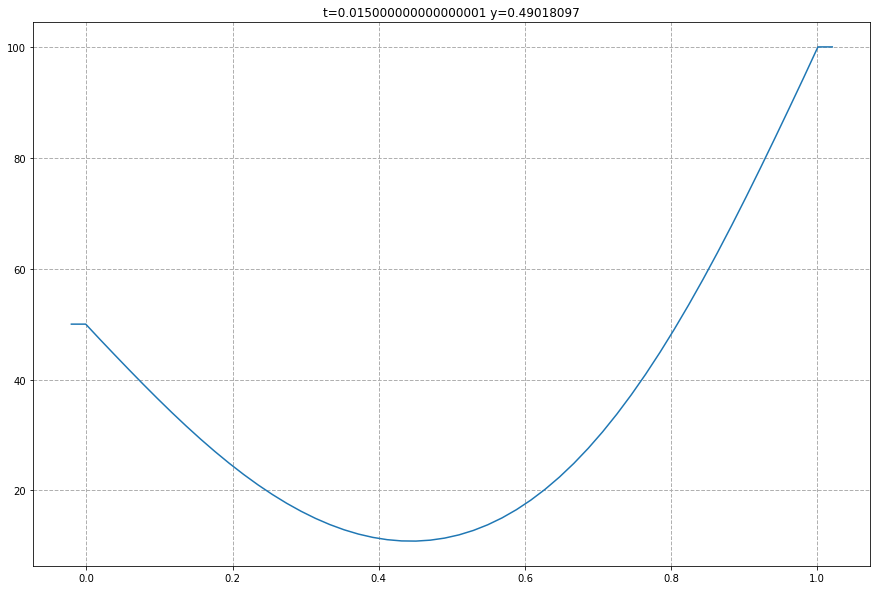

In [9]:
plot_cross(y_cross=4.9018097e-01,time=1,key='C[A]')

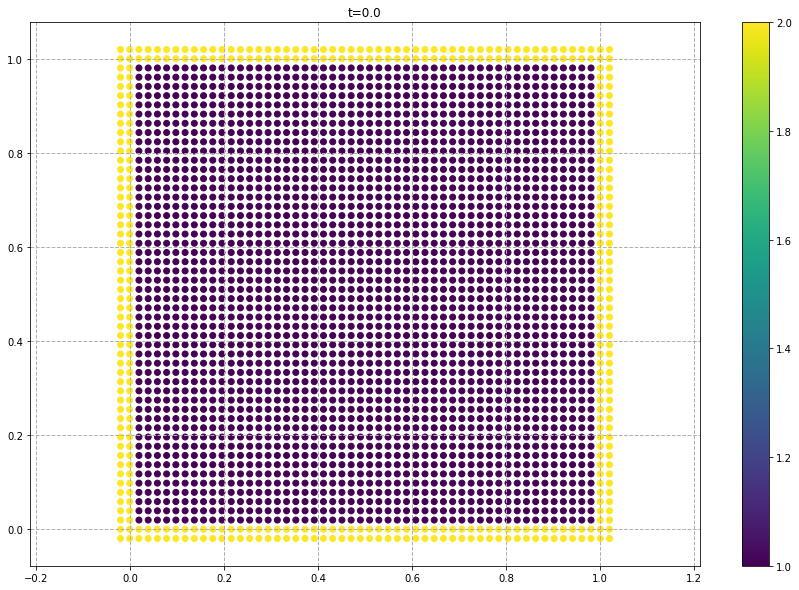

In [10]:
plot_step() # show particle types (wall, )

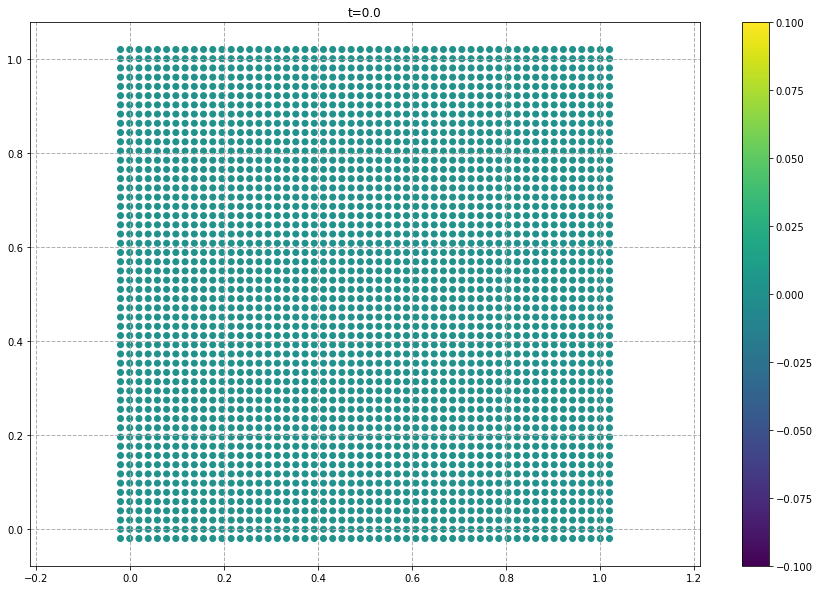

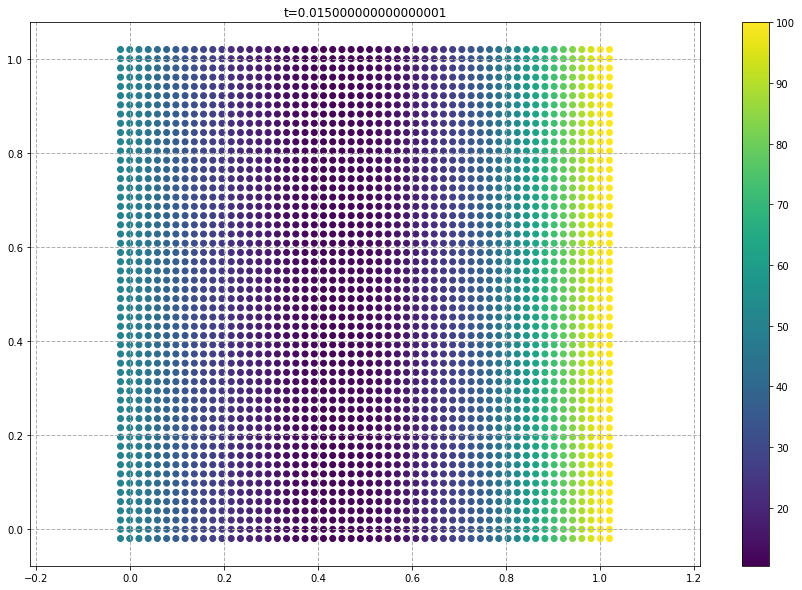

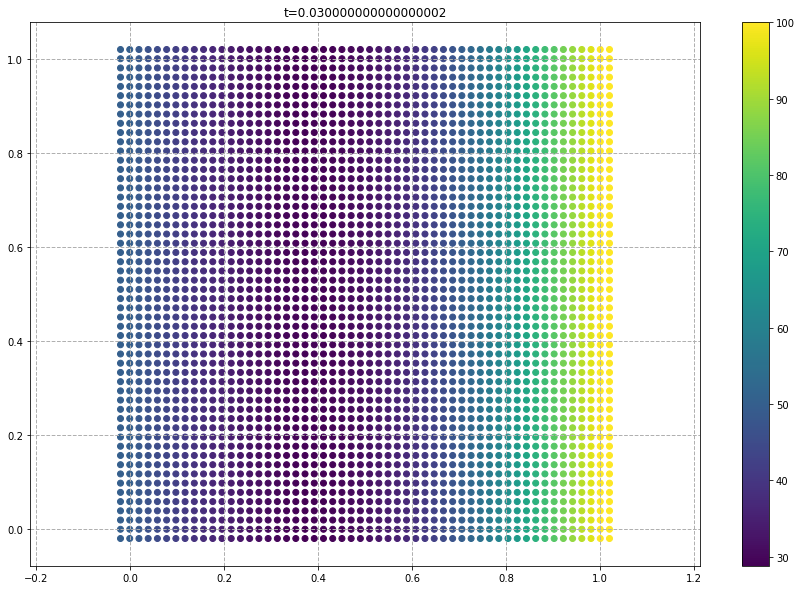

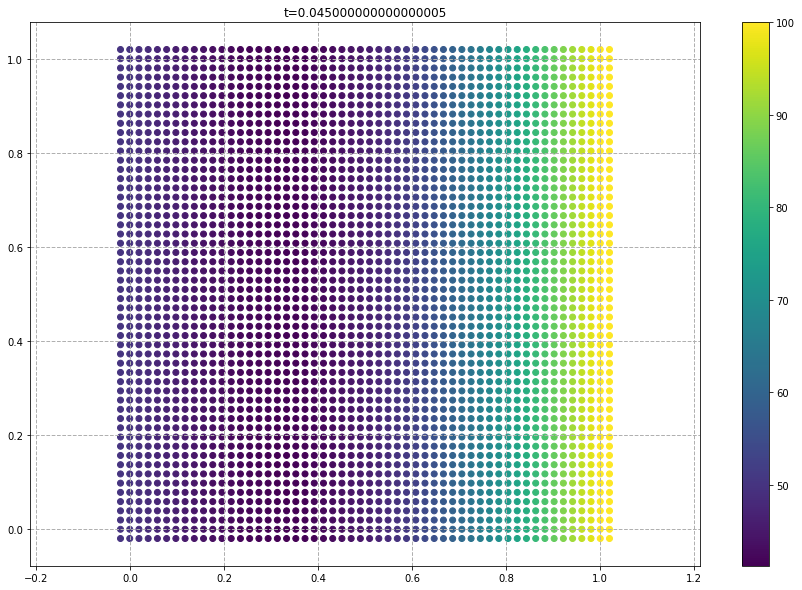

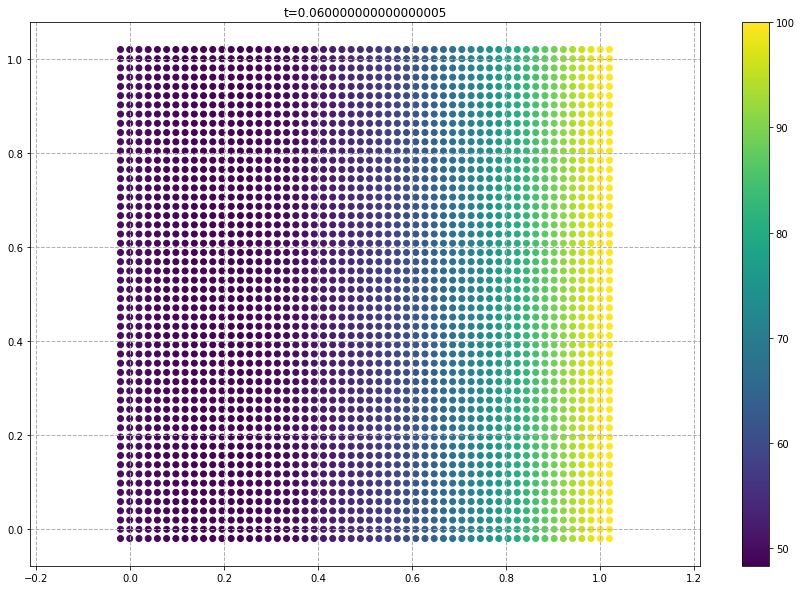

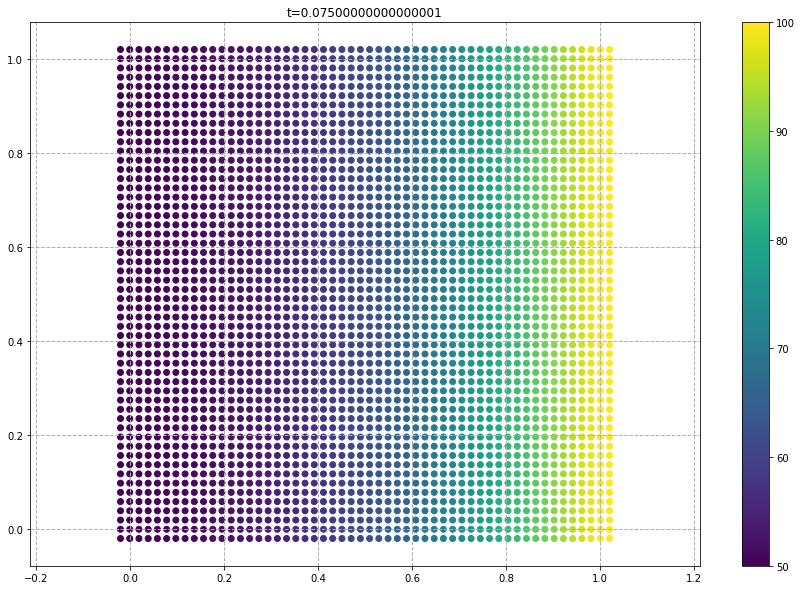

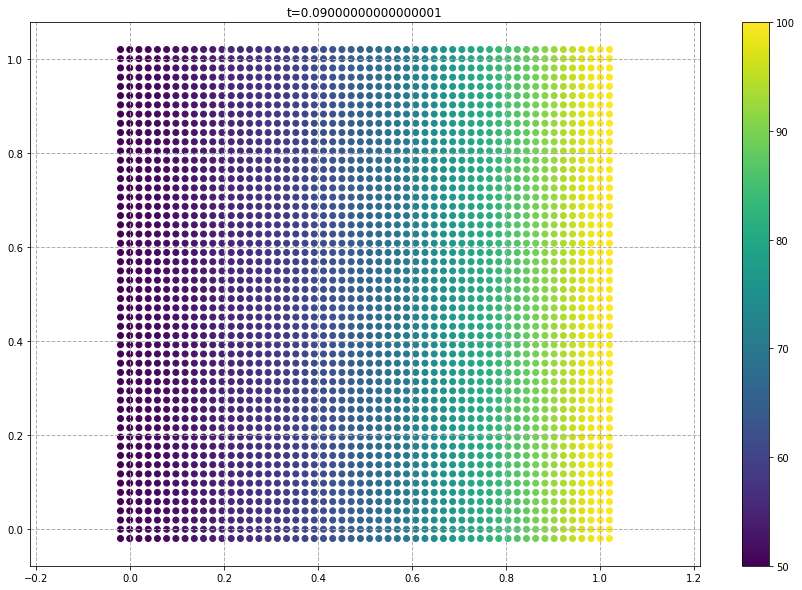

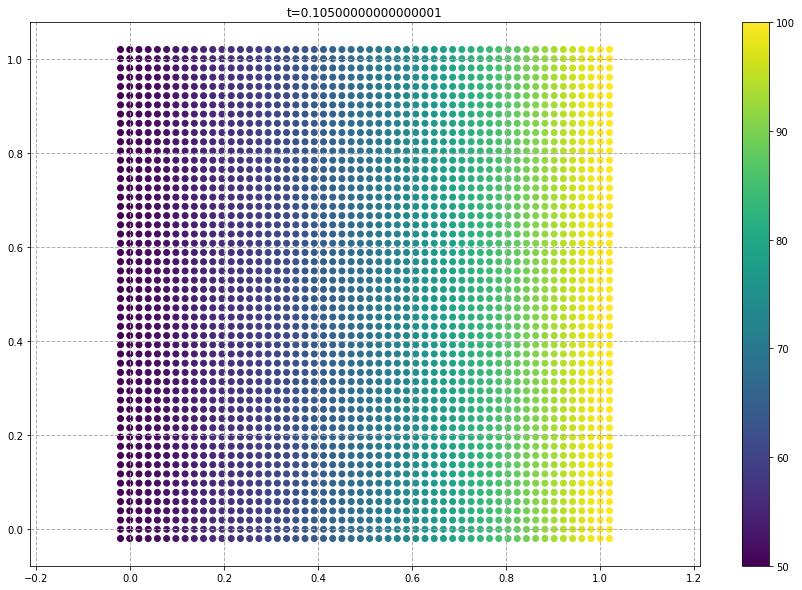

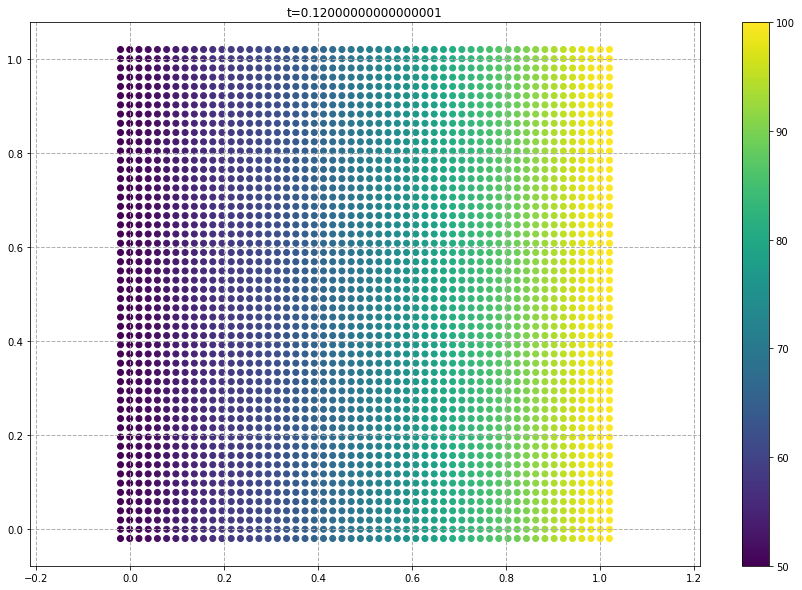

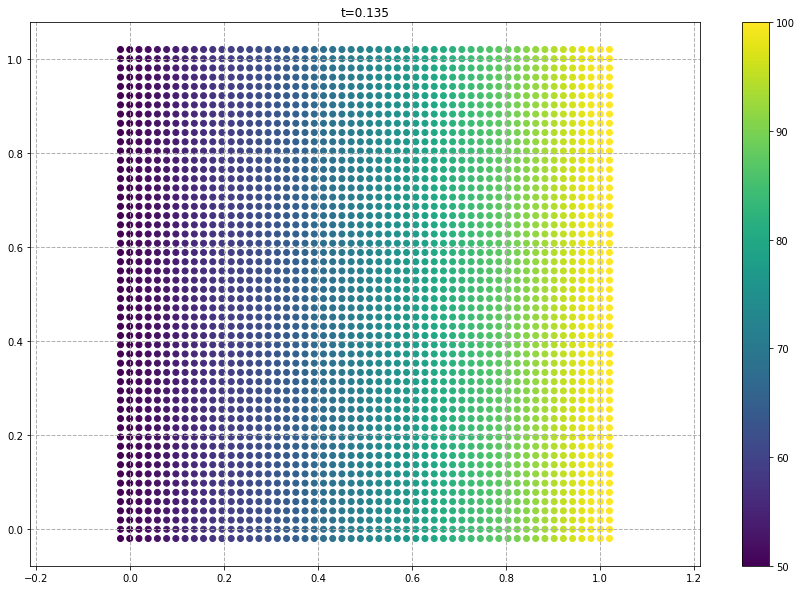

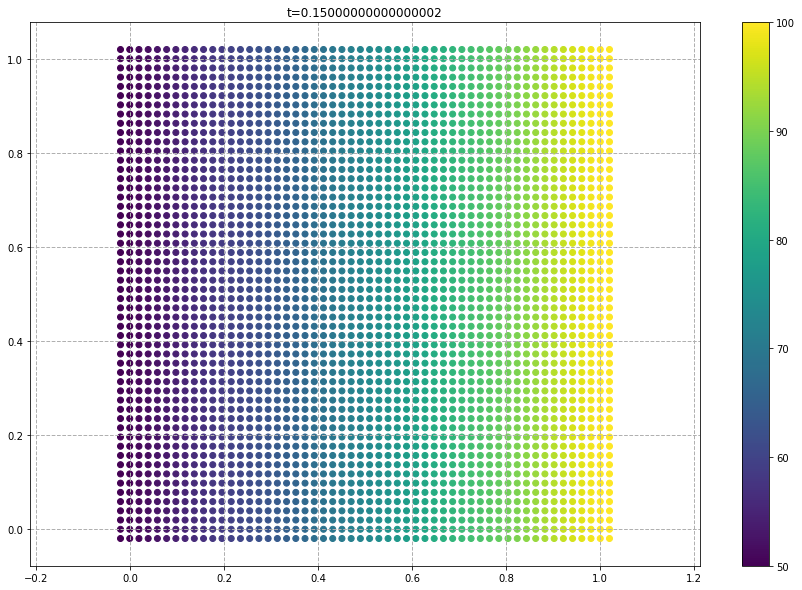

In [11]:
plot_all('C[A]')

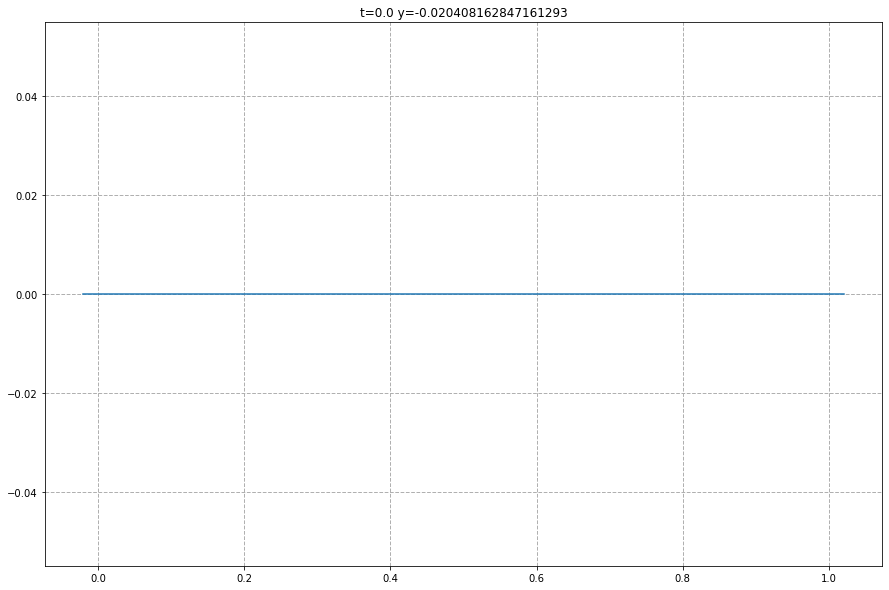

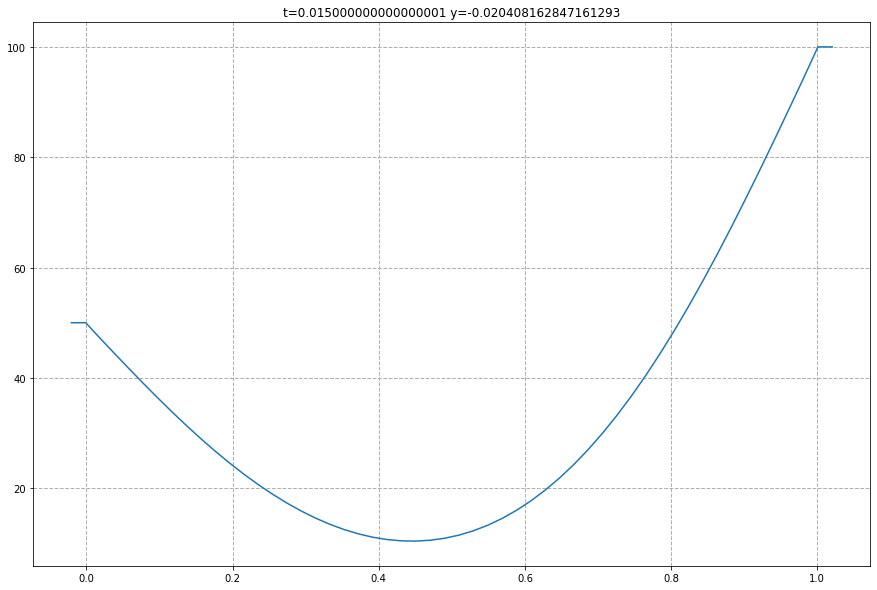

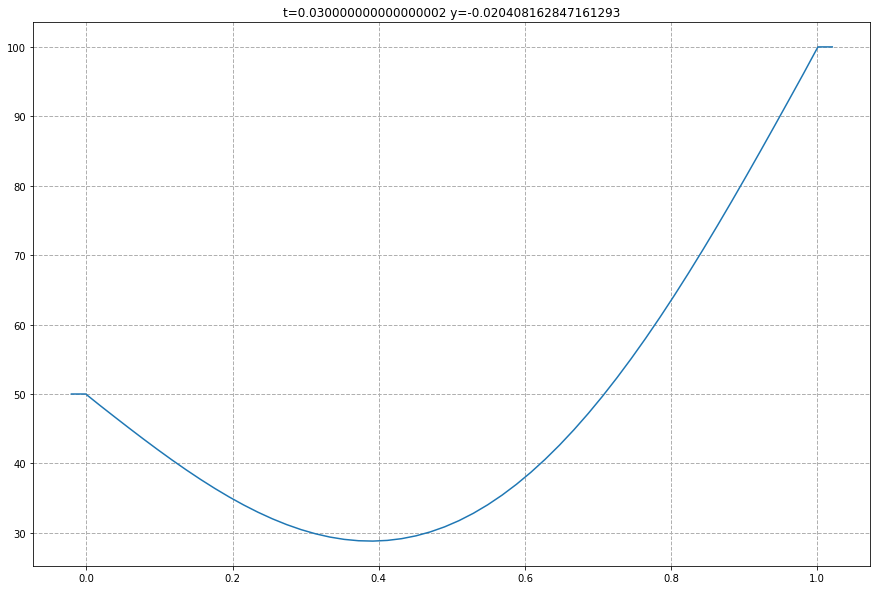

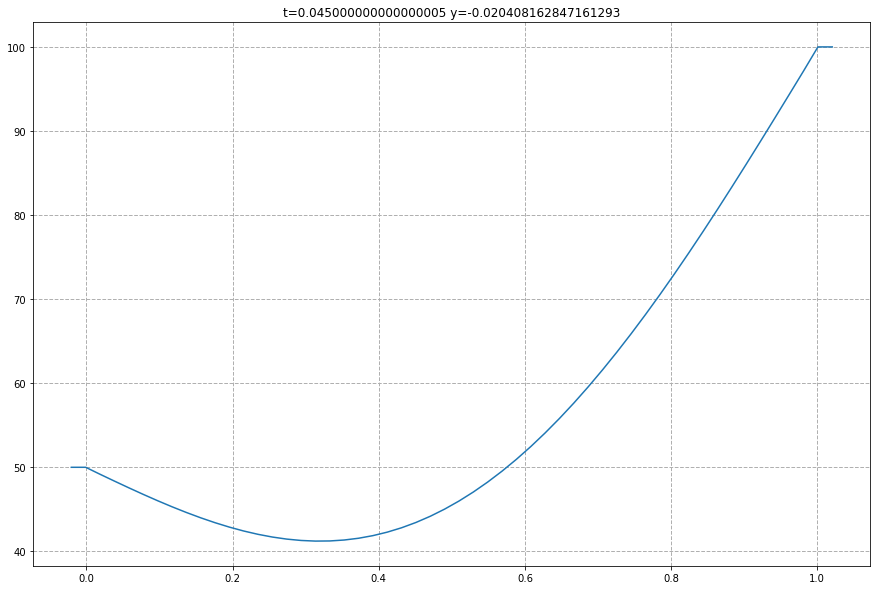

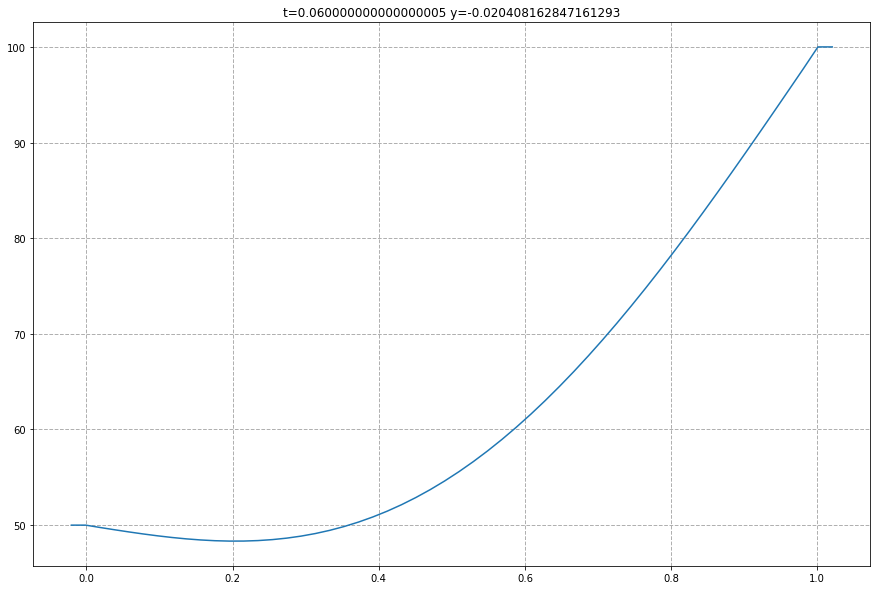

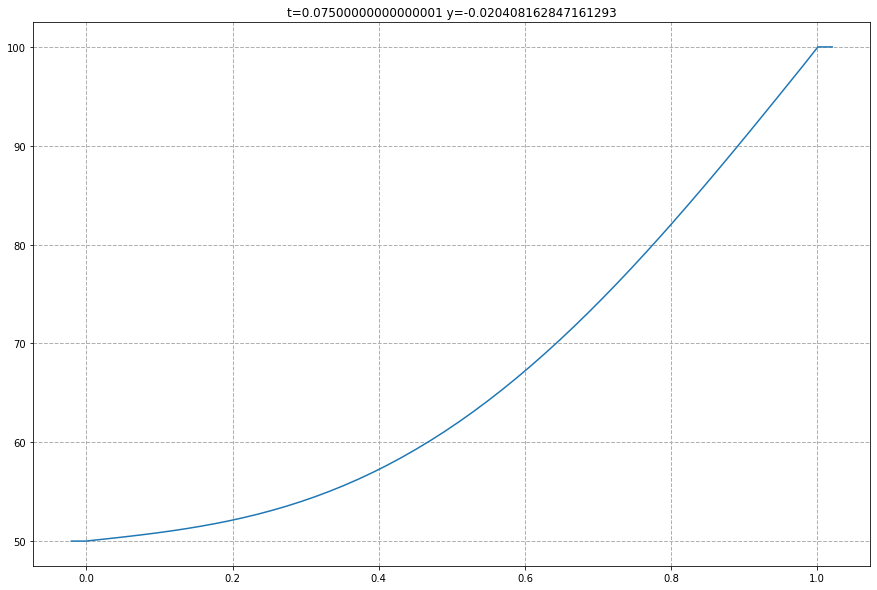

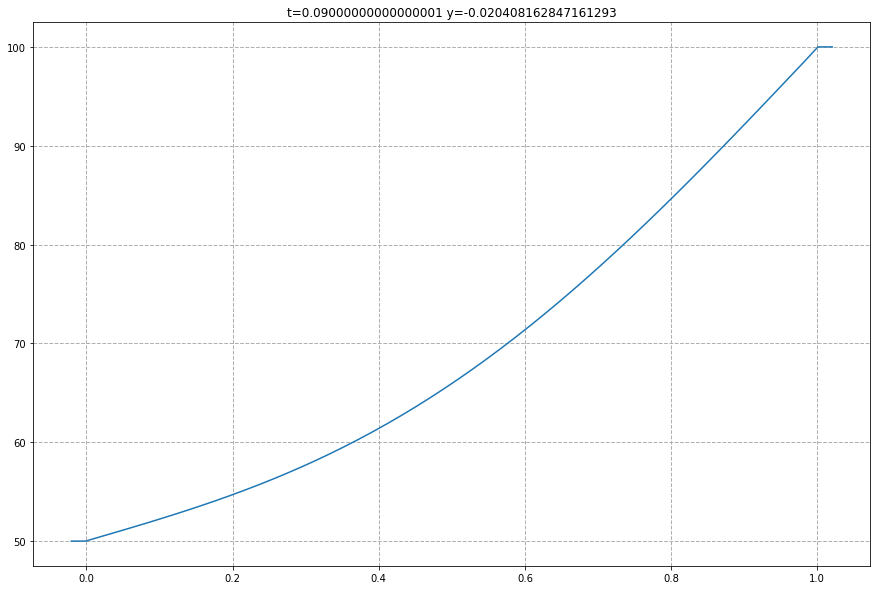

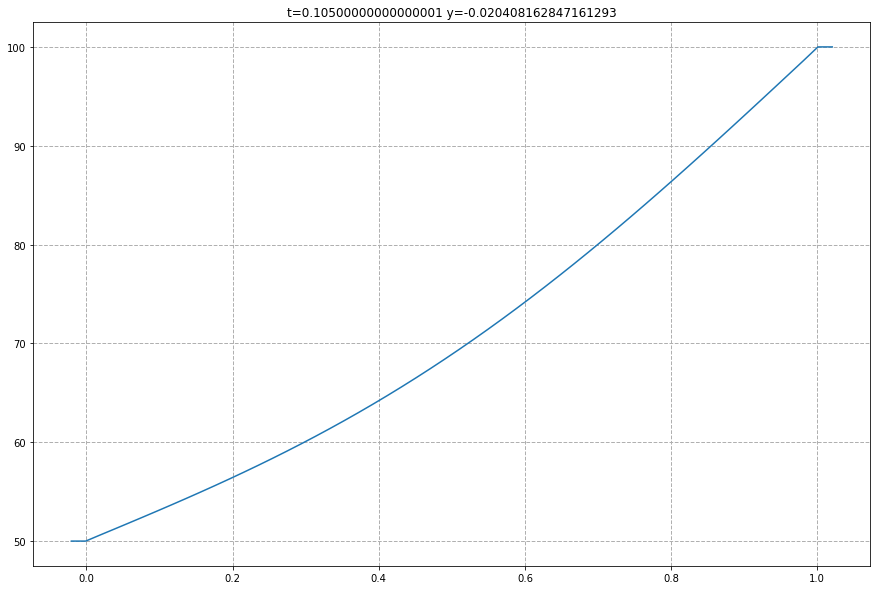

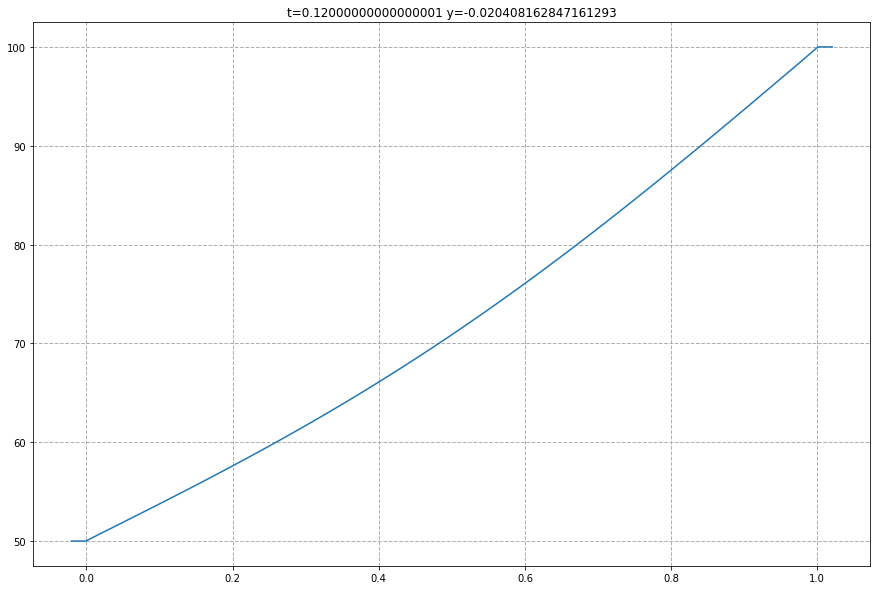

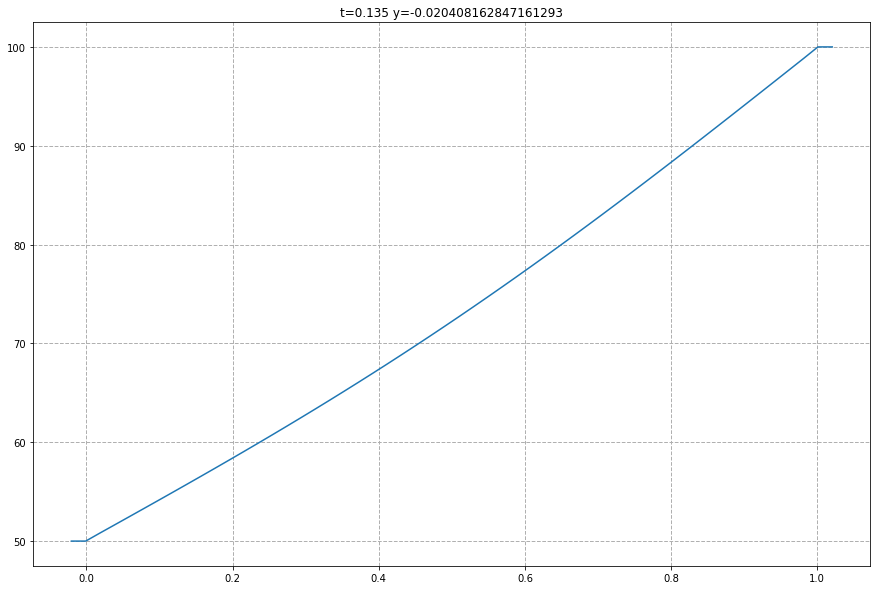

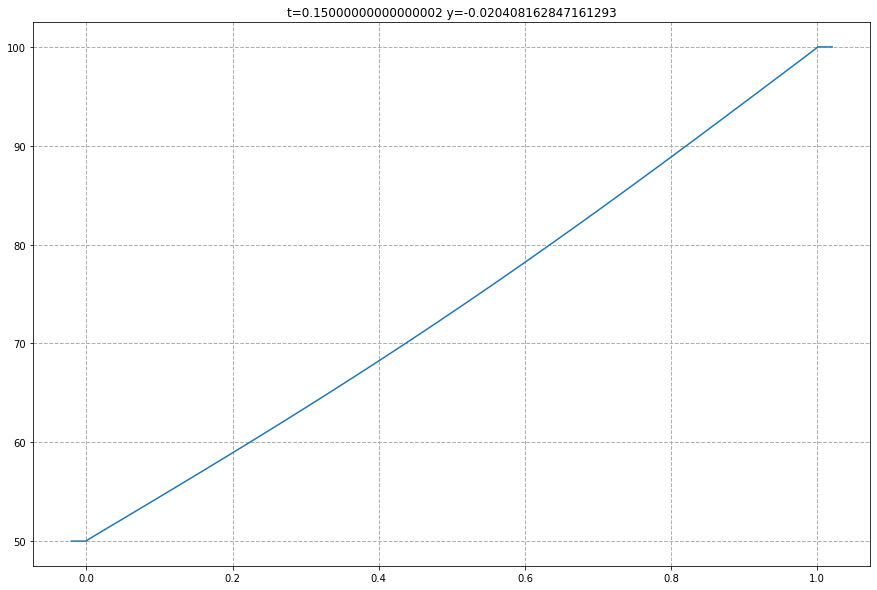

In [12]:
plot_all_cross('C[A]')

In [13]:
result.plot_species("A", -1, deterministic=True)